# APPM 4720 Applied Deep Learning, Spring 2022
## Progress Report 05 - Conditional GANs
### Image-to-Image Translation with Conditional Adversarial Networks
### By Sabrina Liu

Examined and implemented the **Conditional GANs** algorithm as described in 2017 UC Berkeley paper *Image-to-Image Translation with Conditional Adversarial Networks*. Trained the model on the paired `maps` dataset and produced some preliminary results. 

#### References:
* Paper: Isola, et.al. *Image-to-Image Translation with Conditional Adversarial Networks* https://arxiv.org/abs/1611.07004
* Dataset: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/
* Official Repo: https://github.com/affinelayer/pix2pix-tensorflow

This project implemented the referenced framework using Keras API in alignment with the source code from the official repo, which was built in tensorflow v1.

---
## Set Up Environment

#### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/ADL/GAN'
!dir

/content/drive/MyDrive/ADL/GAN
data  images  models  models_100


#### Configuratee GPU Usage


In [4]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [5]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Mar 29 23:16:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
## Architecture Review

The task of **image-to-image translation** involves transforming an input image into an corresponding output image, sometimes requiring the results to be creative rather than deterministic. Generative Adversarial Networks (GANs) are used to achieve this goal with stochastic components. In general, GANs consists of two parts: a generator and a discriminator, and the two models are trained against each other in adversarial. That is, the discriminator is trained to recognize fake synthesized signals from real signals (ground truth), whereas the generator is trained to fool the discriminator by producing better and better like-real products, in each epoch. 

#### Conditional GAN

Unconditional GANs usually involve training the discriminator on only signals produced by the generator, and the generator takes in the input the same way as in the inference time. Conditional GANs adds more information to the training process by feeding some guiding signals to either the discriminator or the generator, or both, in order to add constraints to produce more desirable outputs. 

#### Loss Function

Using $G$ for generator, $D$ for discriminator, $x$ for input, $y$ for ground truth, and $z$ for random noise, the loss function of our **conditional GAN** is to minimize the likelihood for the discriminator to make a mistake (minimizing logarithm will force the antilog number towards 1):

$$ \mathcal{L}_{cGAN}(G, D) = 
   \underbrace{\mathbb{E} _{x,y}[\log D(x,y)]}_{\text{real images}}
 + \underbrace{\mathbb{E}_{x,z}[\log(1-D(x, G(x,z)))]}_{\text{fake images}} $$

Meanwhile, $G$ is trained to maximize the second part of this objective, i.e.

$$ G^* = \arg\min_G\max_D \mathcal{L}_{cGAN}(G,D) $$

The unconditional version of this design is to simply train the discriminator without the input $x$. 

#### Add L1 Loss to Generator

Ultimately, it is the generator model that we want. Previous researches have found that adding L2 loss to the GAN objective is helpful when ground truth is available. This paper pointed out that L2 loss tend to produce blurry results, and L1 loss is used in the generator instead to produce sharper results. 

$$ \mathcal{L}_{L1}(G) = \mathbb{E}_{x,y,z}[|| y - G(x,z) ||_1] $$

So the final objective is 

$$ G^* = \arg\min_G\max_D \mathcal{L}_{cGAN}(G,D) + \lambda \mathcal{L}_{L1}(G) $$

During training, $\lambda=100$ is used.  

#### Generator Structure: U-Net

The architecture chosen for the generator is an **encoder-decoder** structure with **skip-connections**, named U-Net. The encoder consists of 8 convolutional blocks, with increasing numbers of filters from 64 to 512, each activated with `LeakyReLU` after batch normalization. The decoder consists of 8 corresponding deconvolutional blocks which reversely connect to the outputs of each convolutional block by concatenating, activated with `ReLU`, eventually producing a final output in the input dimensions. 

The paper also pointed out that random noises like Gaussian noise used as an input to the generator is not effective for image-to-image translation task. In order to produce stochastic results, dropout is applied to several decoder blocks in the genertor at both training and test time.  

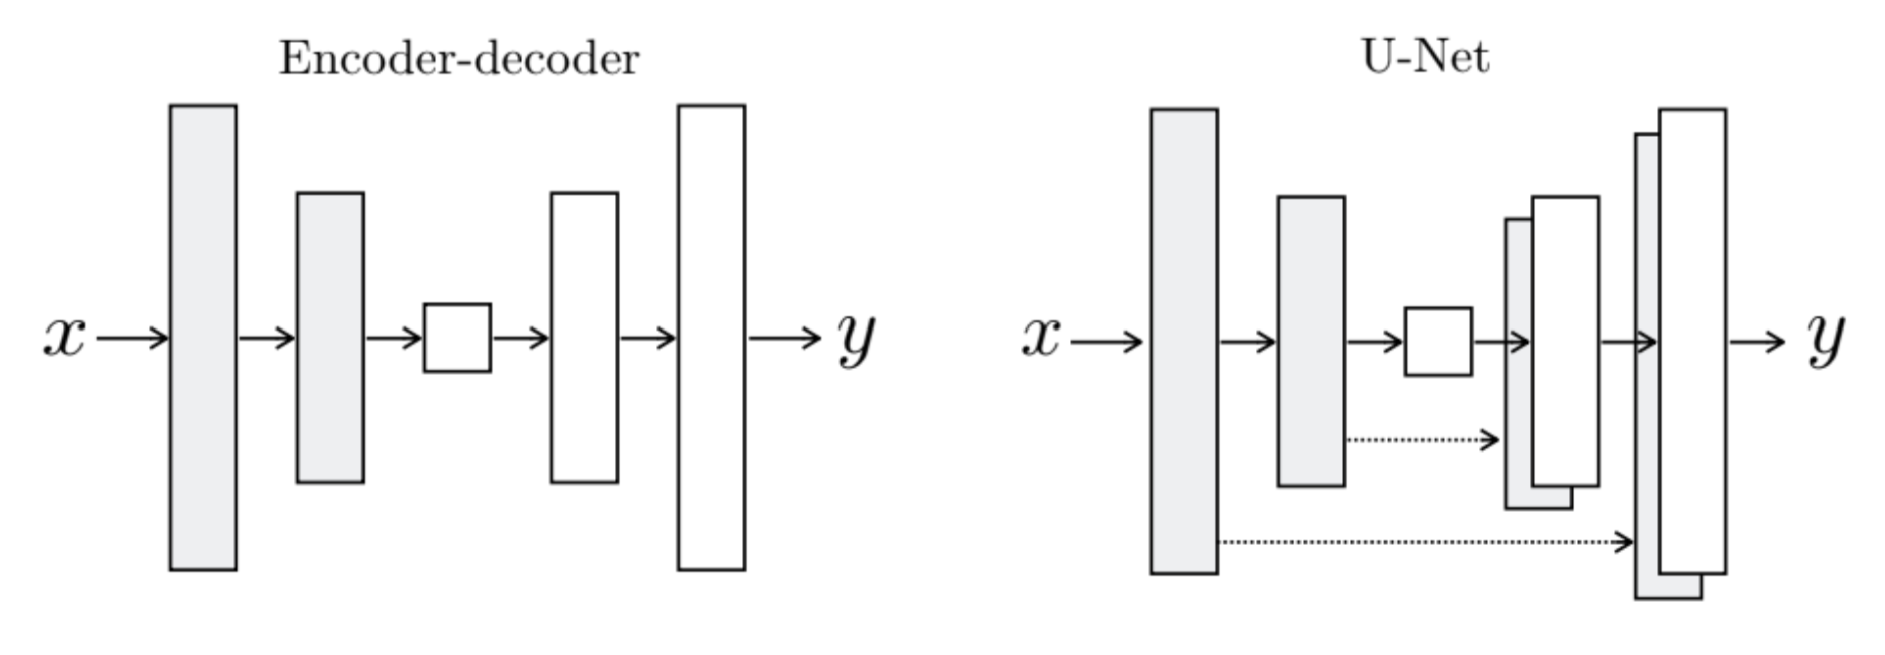

In [7]:
from IPython.display import Image
Image('./images/UNet.png', width=600)

#### Discriminator Structure: PatchGAN

The discriminator is a simple image classifier with several convolutional blocks. Traditionally, the discriminator of a GAN outputs a single binary value indicating whether the synthesized image is real. The paper suggests that classifying image patches instead helps produce sharper results. This is implemented through the output shape of the final convolutional layer. In this project, an average pooling layer was added to produce a single prediction for training simplicity. 

#### Put It Together: Training Cycle

In order to train the generator and the discriminator against each other, in each epoch, the discriminator is first trained knowing that the original target image is real and the generated output image is fake. Then the generator is trained to maximize the probability for the output image to be classified as real, plus the L1 loss against the ground truth. The input image is also fed into the discriminator as additional condition. The training cycle is shown as below. 

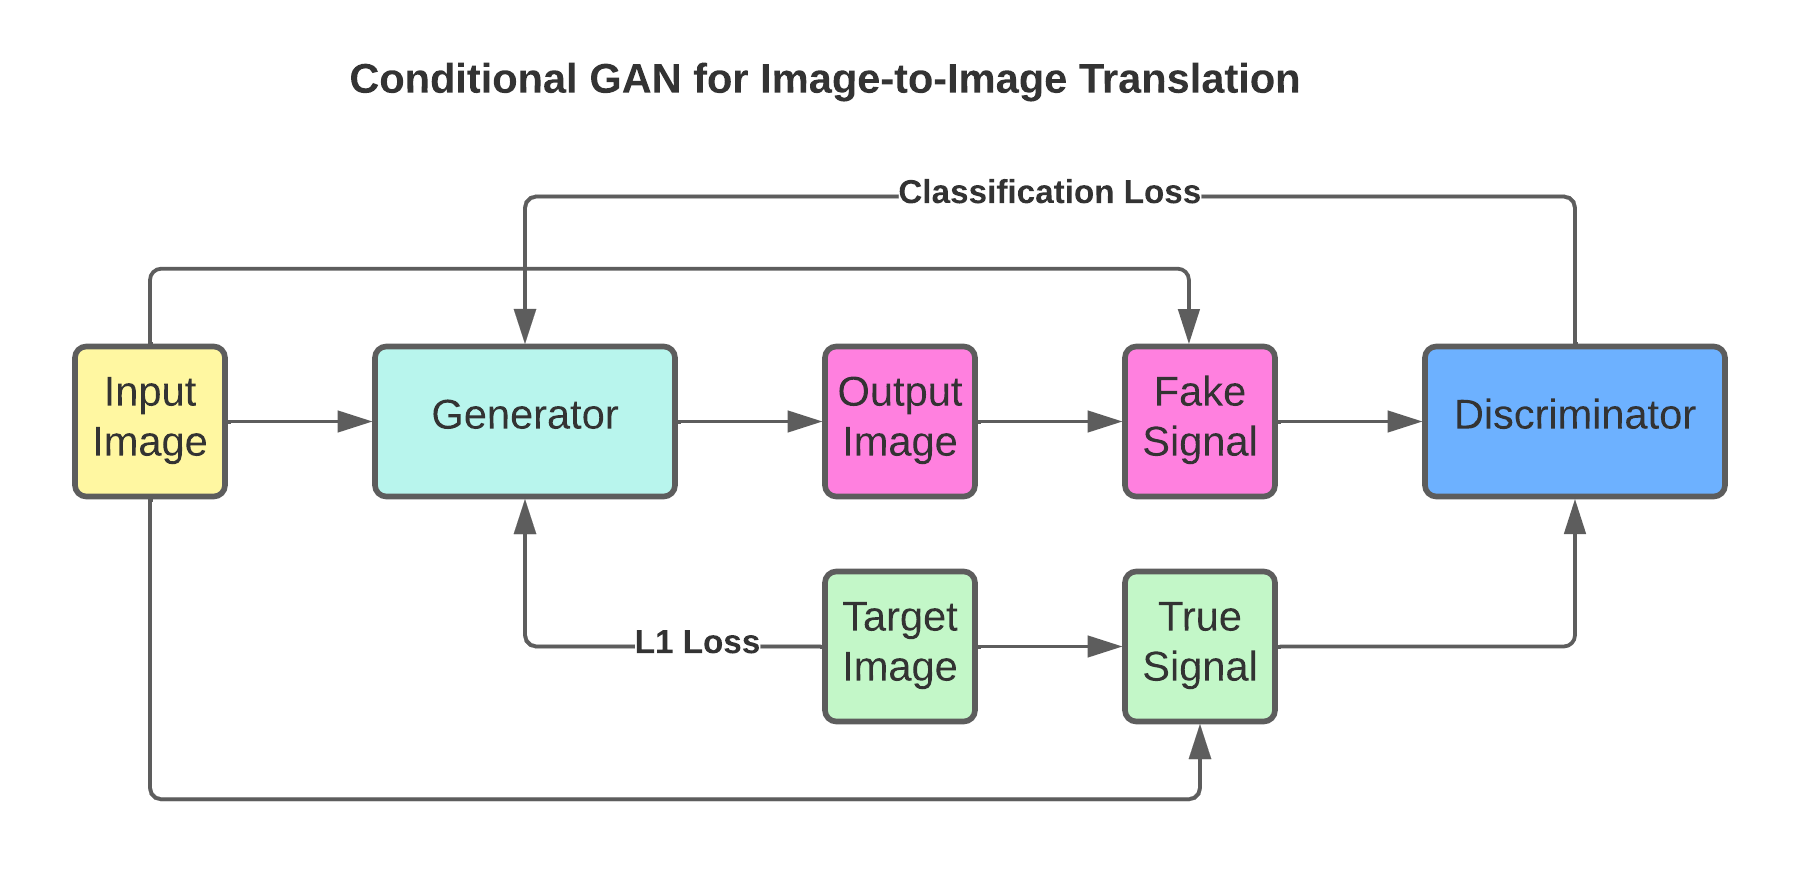

In [8]:
Image('./images/GAN.png', width=600)

---
## The Google Maps Dataset

The `maps` dataset used in this exercise is scraped from Google Maps, including pair-wise aerial and topological maps that are pixel-wise aligned. Below provides preview of 3 images each respectively from the training set and the validation set.

#### Preview the Images

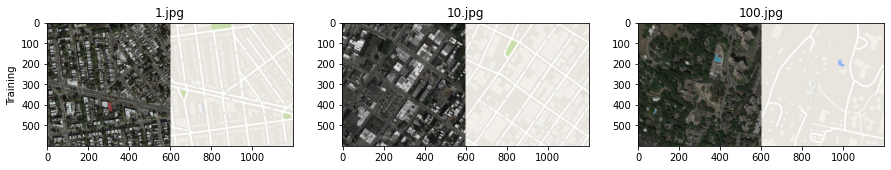

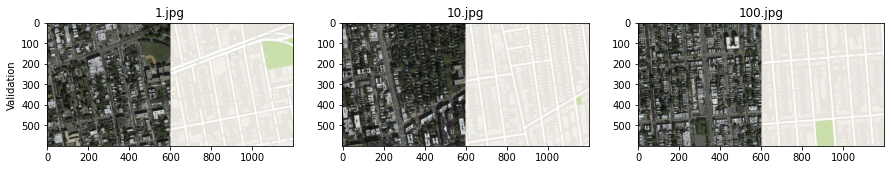

In [9]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

dataset = 'maps'
# dataset = 'edges2shoes'
train_dir = f'./data/{dataset}/train'
valid_dir = f'./data/{dataset}/val'

N_SAMPLES = 3

fig, axes = plt.subplots(1, N_SAMPLES, figsize=(15, 4))
axes[0].set(ylabel='Training')
for i, sample in enumerate(sorted(os.listdir(train_dir))[:N_SAMPLES]):
    img = np.array(Image.open(os.path.join(train_dir, sample)))
    axes[i].set(title=sample)
    axes[i].imshow(img)


fig, axes = plt.subplots(1, N_SAMPLES, figsize=(15, 4))
axes[0].set(ylabel='Validation')
for i, sample in enumerate(sorted(os.listdir(valid_dir))[:N_SAMPLES]):
    img = np.array(Image.open(os.path.join(valid_dir, sample)))
    axes[i].set(title=sample)
    axes[i].imshow(img)

---
#### Load the Dataset into Arrays

In [10]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 1

In [11]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from functools import partial

In [12]:
%%time

load_data = partial(
    image_dataset_from_directory,
    image_size=(256, 512),
    batch_size=None,             # do not create batch
    validation_split=None,       # do not split
    label_mode=None,             # do not include labels
    shuffle=False,               # do not shuffle
    crop_to_aspect_ratio=True,   # do not distort image
)

ds_train = load_data(directory=train_dir)
ds_valid = load_data(directory=valid_dir)

Found 1096 files belonging to 1 classes.
Found 1098 files belonging to 1 classes.
CPU times: user 597 ms, sys: 463 ms, total: 1.06 s
Wall time: 2.8 s


#### Split Images

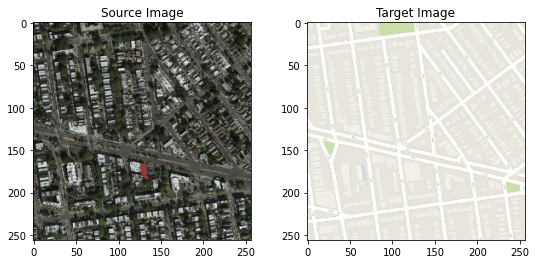

In [13]:
def scale_image(image):              # [0, 255] => [0, 1]
    return image / 255.

def split_image(image):              # (256, 512) => (256, 256) X 2
    img1 = image[:, :256, :]
    img2 = image[:, 256:, :]
    return img1, img2

ds_train = ds_train.map(scale_image).map(split_image)
ds_valid = ds_valid.map(scale_image).map(split_image)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for source, target in ds_train.take(1):
    axes[0].set(title='Source Image'); axes[0].imshow(source)
    axes[1].set(title='Target Image'); axes[1].imshow(target)
    break

#### Create Batch Dataset

In [14]:
ds_train = ds_train.batch(BATCH_SIZE)

---
### Explorary Analysis

#### Split Source and Target

In [15]:
source_images = []
target_images = []

for source, target in ds_train.as_numpy_iterator():
    source_images.append(source)
    target_images.append(target)

source_images = np.squeeze(source_images)
target_images = np.squeeze(target_images)

source_images.shape, target_images.shape

((1096, 256, 256, 3), (1096, 256, 256, 3))

#### Find Source Image Distributions by Color Channel

As shown below, the color distributions are very different from the source to the target images. The target images are obviously brighter than the source images (higher values) in all 3 channels. 

In [16]:
source_R = source_images[:, :, :, 0].flatten()
source_B = source_images[:, :, :, 1].flatten()
source_G = source_images[:, :, :, 2].flatten()

target_R = target_images[:, :, :, 0].flatten()
target_B = target_images[:, :, :, 1].flatten()
target_G = target_images[:, :, :, 2].flatten()

source_R.shape

(71827456,)

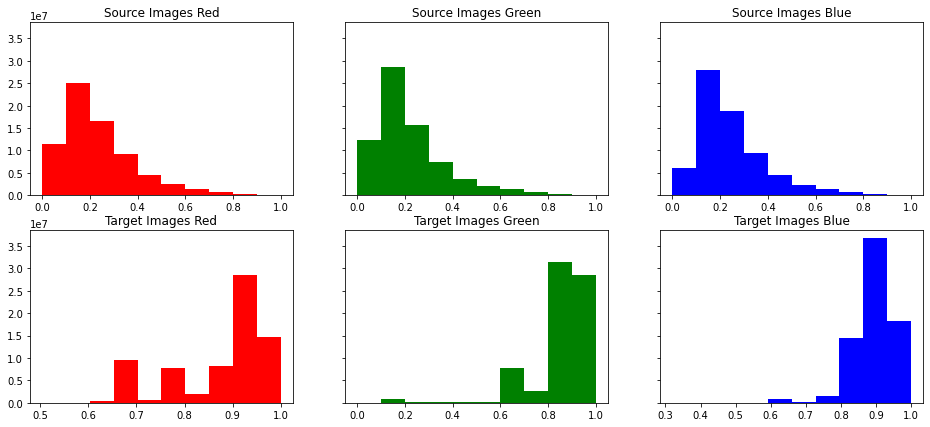

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7), sharey=True)

axes[0, 0].set(title='Source Images Red');   _ = axes[0, 0].hist(source_R, color='r')
axes[0, 1].set(title='Source Images Green'); _ = axes[0, 1].hist(source_G, color='g')
axes[0, 2].set(title='Source Images Blue');  _ = axes[0, 2].hist(source_B, color='b')

axes[1, 0].set(title='Target Images Red');   _ = axes[1, 0].hist(target_R, color='r')
axes[1, 1].set(title='Target Images Green'); _ = axes[1, 1].hist(target_G, color='g')
axes[1, 2].set(title='Target Images Blue');  _ = axes[1, 2].hist(target_B, color='b')

In [18]:
source_R_mu, source_R_sd = source_R.mean(), source_R.std()
source_G_mu, source_G_sd = source_G.mean(), source_G.std()
source_B_mu, source_B_sd = source_B.mean(), source_B.std()

source_mu = (source_R_mu, source_G_mu, source_G_mu)
source_sd = (source_R_sd, source_G_sd, source_B_sd)
source_mu, source_sd

((0.234933, 0.21986203, 0.21986203), (0.15166101, 0.14806701, 0.14555131))

In [19]:
target_R_mu, target_R_sd = target_R.mean(), target_R.std()
target_G_mu, target_G_sd = target_G.mean(), target_G.std()
target_B_mu, target_B_sd = target_B.mean(), target_B.std()

target_mu = (target_R_mu, target_G_mu, target_G_mu)
target_sd = (target_R_sd, target_G_sd, target_B_sd)
target_mu, target_sd

((0.8755754, 0.8622231, 0.8622231), (0.094284646, 0.12999737, 0.060062043))

---
## Model Implementation

In [20]:
from keras import backend as K
K.clear_session()

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Activation

#### Build the Generator

The basic modules of the generator are below encoder and decoder blocks. It takes in an input image and outputs an image of the same size. 

In [22]:
def encoder_block(layer_in, block_id, n_filters):

    # convolutional layer
    kwargs = dict(kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', name=f"conv_{block_id}")

    layer_out = Conv2D(n_filters, **kwargs)(layer_in)
    layer_out = BatchNormalization(name=f"conv_bn_{block_id}")(layer_out)
    layer_out = LeakyReLU(alpha=.2, name=f"conv_leakyrelu_{block_id}")(layer_out)

    return layer_out

In [23]:
def decoder_block(layer_in, block_id, n_filters, p_dropout=.0, concat=True, layer_concat=None):

    kwargs = dict(kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', name=f"deconv_{block_id}")
    layer_out = Conv2DTranspose(n_filters, **kwargs)(layer_in)
    layer_out = BatchNormalization(name=f"deconv_bn_{block_id}")(layer_out)

    if p_dropout > .0:
        layer_out = Dropout(p_dropout, name=f"dropout_{block_id}")(layer_out)

    layer_out = ReLU(name=f"deconv_relu_{block_id}")(layer_out)
    
    if concat:
        layer_out = Concatenate(axis=-1, name=f"concat_{block_id}")([layer_out, layer_concat])


    return layer_out

In [24]:
def generator(input_shape=(256, 256, 3), base_filters=64, summary=False):

    x = Input(shape=input_shape, name='input')
    z = x
    
    scale_factors = [1, 2, 4, 8, 8, 8, 8, 8]
    dropout_rates = [.0, .5, .5, .5, .0, .0, .0, 0]

    feature_maps = []

    for i, factor in enumerate(scale_factors):
        z = encoder_block(z, block_id=i+1, n_filters=base_filters * factor)
        feature_maps.append(z)  # prepare for skip connections

    scale_factors.reverse()    # reverse factors for up sampling
    feature_maps.reverse()

    for i, (factor, dropout, feature) in enumerate(zip(scale_factors, dropout_rates, feature_maps[1:])):
        z = decoder_block(z, block_id=i+1, n_filters=base_filters * factor, p_dropout=dropout, layer_concat=feature)
    z = decoder_block(z, block_id=i+2, n_filters=3, concat=False)
    z = Activation('tanh', name='output')(z)

    model = Model(inputs=x, outputs = z, name='Generator')
    
    if summary:
        display(model.summary(positions=[.35, .63, .72, 1]))
    
    return model

_ = generator(summary=True)

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                     Output Shape               Param #  Connected to                
 input (InputLayer)               [(None, 256, 256, 3)]      0        []                          
                                                                                                  
 conv_1 (Conv2D)                  (None, 128, 128, 64)       3136     ['input[0][0]']             
                                                                                                  
 conv_bn_1 (BatchNormalization)   (None, 128, 128, 64)       256      ['conv_1[0][0]']            
                                                                                                  
 conv_leakyrelu_1 (LeakyReLU)     (None, 128, 128, 64)       0        ['conv_bn_1[0][0]']         
                                                                                          

None

#### Build the Discriminator

The discriminator takes in concatenated images (input and output/target) and outputs a single value activated by sigmoid function towards binary targets. 

In [25]:
def discriminator(input_shape=(256, 256, 6), base_filters=64, summary=False):
    """
    input = concat of [input_image, target_image] on axis=-1
    """
    x = Input(shape=input_shape, name='input')
    z = x
    
    scale_factors = [1, 2, 4, 8]

    for i, factor in enumerate(scale_factors):
        z = encoder_block(z, block_id=i+1, n_filters=base_filters * factor)
    
    # map to 1 filter
    z = Conv2D(filters=1, kernel_size=4, strides=1, name=f"conv_{i+2}")(z)
    z = GlobalAveragePooling2D(name='GAP')(z)      # self-modified
    z = Activation('sigmoid', name='output')(z)

    model = Model(inputs=x, outputs = z, name='Discriminator')
    
    if summary:
        display(model.summary(positions=[.5, .9, 1]))
    
    return model

_ = discriminator(summary=True)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                   Output Shape              Param #
 input (InputLayer)             [(None, 256, 256, 6)]     0      
                                                                 
 conv_1 (Conv2D)                (None, 128, 128, 64)      6208   
                                                                 
 conv_bn_1 (BatchNormalization)  (None, 128, 128, 64)     256    
                                                                 
 conv_leakyrelu_1 (LeakyReLU)   (None, 128, 128, 64)      0      
                                                                 
 conv_2 (Conv2D)                (None, 64, 64, 128)       131200 
                                                                 
 conv_bn_2 (BatchNormalization)  (None, 64, 64, 128)      512    
                                                                 
 conv_leakyrelu_2 (LeakyReLU)   (None, 64, 64, 128)  

None

#### Training Loop

The original paper uses a simple normalization method to map the pixel values from [0, 1] to [-1, 1] by scaling and shifting. In this project, normalization with mean and standard error was also experimented with which did not produce very different results. So the original method was implemented. 

In [26]:
from tensorflow.keras.optimizers import Adam
D_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
G_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

In [27]:
def normalize(image_batch, mu, sd):          # [0, 1] => [-1, 1]
    # R = tf.slice(image_batch, [0, 0, 0, 0], [-1, -1, -1, 1]); R -= mu[0]; R /= sd[0]; 
    # G = tf.slice(image_batch, [0, 0, 0, 1], [-1, -1, -1, 1]); G -= mu[1]; G /= sd[1]; 
    # B = tf.slice(image_batch, [0, 0, 0, 2], [-1, -1, -1, 1]); B -= mu[2]; B /= sd[2]; 
    return image_batch * 2 - 1
    # return tf.concat([R, G, B], axis=3)

def denormalize(image_batch, mu, sd):        # [-1, 1] => [0, 1]
    # R = tf.slice(image_batch, [0, 0, 0, 0], [-1, -1, -1, 1]); R *= sd[0]; R += mu[0]; 
    # G = tf.slice(image_batch, [0, 0, 0, 1], [-1, -1, -1, 1]); G *= sd[1]; G += mu[1]; 
    # B = tf.slice(image_batch, [0, 0, 0, 2], [-1, -1, -1, 1]); B *= sd[2]; B += mu[2]; 
    return (image_batch + 1) / 2
    return tf.clip_by_value(tf.concat([R, G, B], axis=3), -1, 1)

In [28]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.G = generator()
        self.D = discriminator()
        self.G_NN_weight=1.0
        self.G_L1_weight=100.0
        self.epsilon=1e-12

    def compile(self):
        super().compile()
    
    @tf.function
    def train_step(self, data):

        source, target = data
        source = normalize(source, source_mu, source_sd)    # [0, 1] => [-1, 1]
        target = normalize(target, target_mu, target_sd)    # [0, 1] => [-1, 1]

        with tf.GradientTape() as D_tape, tf.GradientTape() as G_tape:

            output = self.G(source, training=True)                # (B, 256, 256, 3) => (B, 256, 256, 3)

            real = tf.concat((source, target), axis=-1)
            fake = tf.concat((source, output), axis=-1)

            predict_real = self.D(real, training=True)            # (B, 256, 256, 6) => (B, 1)
            predict_fake = self.D(fake, training=True)            # (B, 256, 256, 6) => (B, 1)

            # train discriminator
            D_loss = tf.reduce_mean(-(                            # minimize -log will get input close to 1
                  tf.math.log(predict_real + self.epsilon)        # predict_real => 1
                + tf.math.log(1 - predict_fake + self.epsilon))   # predict_fake => 0
            )
            D_grad = D_tape.gradient(D_loss, self.D.trainable_variables)
            D_optimizer.apply_gradients(zip(D_grad, self.D.trainable_variables))

            # train generator
            G_loss_NN = tf.reduce_mean(-tf.math.log(predict_fake + self.epsilon))
            G_loss_L1 = tf.reduce_mean(tf.abs(target - output))
            G_loss = G_loss_NN * self.G_NN_weight + G_loss_L1 * self.G_L1_weight

            G_grad = G_tape.gradient(G_loss, self.G.trainable_variables)
            G_optimizer.apply_gradients(zip(G_grad, self.G.trainable_variables))

        # track discriminator performance
        D_real = tf.reduce_mean(predict_real)
        D_fake = tf.reduce_mean(predict_fake)

        results = {m.name: m.result() for m in self.metrics}
        results.update(dict(G_loss=G_loss, D_loss=D_loss, D_real=D_real, D_fake=D_fake))

        return results

    def __call__(self, source, training=False):    # set training=True due to tensorflow bug
        source = normalize(source, source_mu, source_sd)  # [-1, 1]
        output = self.G(source, training=True)
        return denormalize(output, target_mu, target_sd)  # [0, 1]

model = ConditionalGAN()
model.compile()

---
## Training

The training process is set to run 10 epochs each time, with the weights and training performance saved and loaded for later use. 

In [29]:
!dir

data  images  models  models_100


In [30]:
import os
import pickle

model_name = "Conditional GAN"
model_file = f"./models/{model_name}.tf"
hist_file = "./models/model_history.pkl"

if not os.path.exists('./models'):
    os.mkdir('./models')

current_epoch = 0
# load pre-trained model and history if available
if os.path.exists(f"{model_file}.index") and os.path.exists(hist_file):
    print(f"\nLoading model weights for {model_name}...")
    model.load_weights(model_file)
    print(f"\nLoading model history for {model_name}...")
    with open(hist_file, 'rb') as pickle_file:
        model_history = pickle.load(pickle_file)

    current_epoch = len(model_history['D_loss'])


Loading model weights for Conditional GAN...

Loading model history for Conditional GAN...


In [31]:
N_EPOCHS = 10
N_WORKERS = 1000

fit_dict = dict(
    shuffle=True,
    batch_size=BATCH_SIZE, 
    epochs=N_EPOCHS, 
    verbose=1,
    workers=N_WORKERS, 
    use_multiprocessing=True
)

print(f"\nTraining model {model_name}...")
history = model.fit(ds_train, **fit_dict)
if current_epoch != 0:
    for (loss, old_values), new_values in zip(model_history.items(), history.history.values()):
        model_history[loss].extend(history.history[loss])
else:
    model_history = history.history

print(f"\nSaving model history for {model_name}...")
with open('./models/model_history.pkl', 'wb') as pickle_file:
    pickle.dump(model_history, pickle_file)

current_epoch += N_EPOCHS
print(f"\nSaving model weights for {model_name} epoch {current_epoch}...")
model.save_weights(model_file)


Training model Conditional GAN...
Epoch 1/10
1096/1096 [==============================] - 76s 55ms/step - G_loss: 13.5406 - D_loss: 0.1875 - D_real: 0.9395 - D_fake: 0.0603
Epoch 2/10
1096/1096 [==============================] - 61s 55ms/step - G_loss: 13.3714 - D_loss: 0.2060 - D_real: 0.9346 - D_fake: 0.0653
Epoch 3/10
1096/1096 [==============================] - 61s 55ms/step - G_loss: 13.5162 - D_loss: 0.2400 - D_real: 0.9280 - D_fake: 0.0726
Epoch 4/10
1096/1096 [==============================] - 61s 55ms/step - G_loss: 13.6819 - D_loss: 0.1792 - D_real: 0.9449 - D_fake: 0.0551
Epoch 5/10
1096/1096 [==============================] - 61s 55ms/step - G_loss: 13.4621 - D_loss: 0.2087 - D_real: 0.9335 - D_fake: 0.0665
Epoch 6/10
1096/1096 [==============================] - 61s 55ms/step - G_loss: 13.5241 - D_loss: 0.1216 - D_real: 0.9566 - D_fake: 0.0435
Epoch 7/10
1096/1096 [==============================] - 61s 55ms/step - G_loss: 13.4336 - D_loss: 0.2657 - D_real: 0.9240 - D_fake:

#### Generator Loss and Discriminator Loss

When plotting the generator loss and the discriminator loss side by side, it can be clearly observed that as the generator performance improves, the discriminator performance decreases, and vice versa. Both models get improved in the back-and-force process over time. 

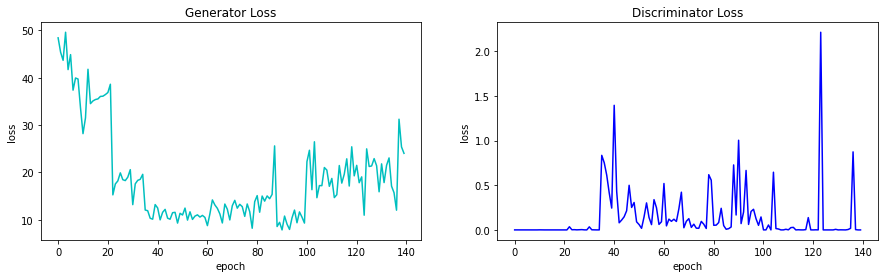

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(model_history['G_loss'], color='c')
axes[1].plot(model_history['D_loss'], color='b')
axes[0].set(title='Generator Loss', xlabel='epoch', ylabel='loss')
axes[1].set(title='Discriminator Loss', xlabel='epoch', ylabel='loss')
plt.show()

#### Discriminator Results

It is also interesting to check how the discriminator made decisions on the given real and fake images during training. It can be seen that in the beginning the discriminator was very confident at telling the fake from the real. But as time goes, the prediction scores in both cases start to oscillate, becoming less certain, with the two scores meeting in the middle, but then improving again after a while. 


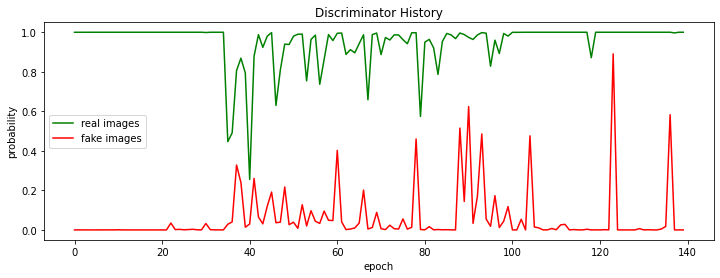

In [33]:
plt.figure(figsize=(12, 4))

_ = plt.plot(model_history['D_real'], color='g', label='real images')
_ = plt.plot(model_history['D_fake'], color='r', label='fake images')
plt.title('Discriminator History')
plt.xlabel('epoch'); plt.ylabel('probability')
plt.legend()
plt.show()

---
## Image-to-Image Translation Results

Let's randomly choose several source images from the validation set and check what the generator is able to produce. Because dropout is implemented, `training=True` configuration is specified for inference calls, but no gradient is calculated. 

In [34]:
def show_example(sample_id):

    input, truth = list(ds_valid.as_numpy_iterator())[sample_id]  # [0, 1]
    output = model.predict(tf.expand_dims(input, axis=0))[0]      # [-1, 1]

    fig, axes = plt.subplots(1, 3, figsize=(13, 4))
    axes[0].set(title='Input Image');  _ = axes[0].imshow(input)
    axes[1].set(title='Ground Truth'); _ = axes[1].imshow(truth)
    axes[2].set(title='Output Image'); _ = axes[2].imshow(output)

    for i in range(3):
        axes[i].axis('off')

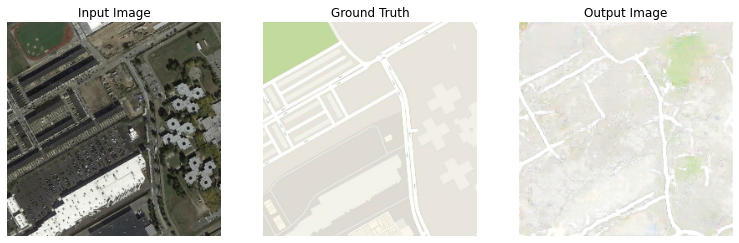

In [35]:
show_example(8)

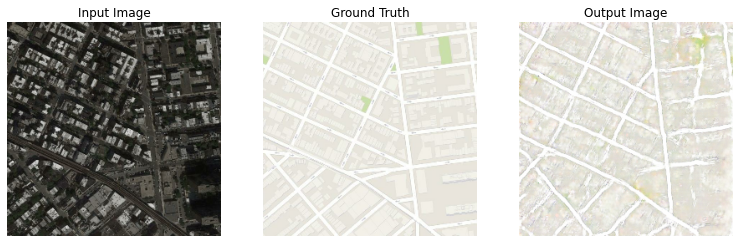

In [36]:
show_example(12)

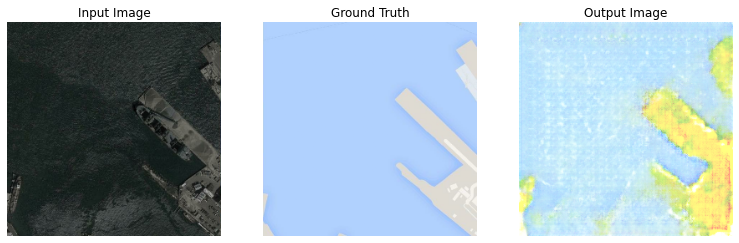

In [37]:
show_example(100)

I'd say that the output quality is a little blurry but can pass for a map. 